### 4.21 Estimating the model generalization error with CV - Demo

In [ ]:
import numpy as np
import pandas as pd
from scipy.special import comb

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from sklearn.model_selection import (
    KFold,
    RepeatedKFold,
    LeaveOneOut,
    LeavePOut,
    StratifiedKFold,
    cross_validate,
    train_test_split
)

# load data
breast_cancer_X, breast_cancer_y = load_breast_cancer(return_X_y = True)
X = pd.DataFrame(breast_cancer_X)
y = pd.Series(breast_cancer_y).map({0:1, 1:0})

# data seems a bit imbalanced
print(type(breast_cancer_X), type(breast_cancer_y))
y.value_counts() / len (y)

# split into training/testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.3, random_state = 0
)
X_train.shape, X_test.shape


## Performing Cross-Validation
# build a model
logReg = LogisticRegression(
    penalty='l2', C=10, solver='liblinear', random_state=4, max_iter=10000
)

# K-Fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=4)

# Repeated K-Fold CV
rkf = RepeatedKFold(
    n_splits=5,
    n_repeats=10,
    random_state=4
)

# LOO-CV
loo = LeaveOneOut()

# Stratified K-Fold
skf = StratifiedKFold(n_splits = 5, shuffle=True, random_state=4)

# perform CV
clf = cross_validate(
    logReg,
    X_train,
    y_train,
    scoring='accuracy', 
    return_train_score=True,
    cv=kf # rkf # loo # skf
)

clf['test_score']
clf['train_score']

# to evaluate how overfit a model is, we can evaluate the (mean +- SD) of the training and testing scores to make sure they overlap
print('mean train accuracy: ', np.mean(clf['train_score']), ' +- ', np.std(clf['train_score']))
print('mean test accuracy: ', np.mean(clf['test_score']), ' +- ', np.std(clf['test_score']))

### 4.22 Cross-Validation for Hyperparameter Tuning - Demo

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from sklearn.model_selection import (
    KFold,
    RepeatedKFold,
    LeaveOneOut,
    LeavePOut,
    StratifiedKFold,
    GridSearchCV,
    train_test_split
)

## load data
breast_cancer_X, breast_cancer_y = load_breast_cancer(return_X_y = True)
X = pd.DataFrame(breast_cancer_X)
y = pd.Series(breast_cancer_y).map({0:1, 1:0})

# split into training/testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.3, random_state = 0
)

## Performing Cross-Validation
# build a model
logReg = LogisticRegression(
    penalty='l2', C=10, solver='liblinear', random_state=4, max_iter=10000
)


# hyperparameter space
param_grid = dict(
    penalty = ['l1', 'l2'],
    C=[0.1, 1, 10]
)

# K-Fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=4)

# Repeated K-Fold CV
rkf = RepeatedKFold(
    n_splits=5,
    n_repeats=10,
    random_state=4
)

# LOO-CV
loo = LeaveOneOut()

# Stratified K-Fold
skf = StratifiedKFold(n_splits = 5, shuffle=True, random_state=4)

# search and score
clf = GridSearchCV(
    logReg,
    param_grid,
    scoring='accuracy',
    cv=kf, # rkf, # loo, # skf
    refit=True #refits the best model to the entire dataset
)

search = clf.fit(X_train, y_train)


# best hyperparameters
search.best_params_

results = pd.DataFrame(search.cv_results_)[['params', 'mean_test_score', 'std_test_score']]
print(results.shape)
results

results.sort_values(by = 'mean_test_score', ascending=False, inplace=True)
results.reset_index(drop=True, inplace=True)

results['mean_test_score'].plot(yerr=[results["std_test_score"], results["std_test_score"]], subplots=True)
plt.ylabel('Mean Accuracy')
plt.xlabel('Hyperparameter Space')

train_preds = search.predict(X_train)
test_preds = search.predict(X_test)

print('Train Accuracy: ', accuracy_score(y_train, train_preds))
print('Test Accuracy: ', accuracy_score(y_test, test_preds))

### 4.24 Group Cross-Validation Demo

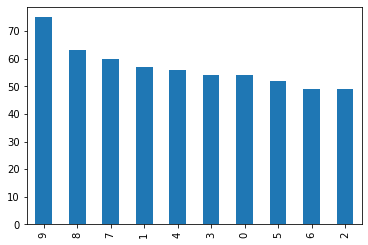

In [12]:
"At times, our data has a grouping variable that identifies a "
"    source of random variability. To account for this variability, "
"    we need to update our CV scheme"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, make_scorer)

from sklearn.model_selection import (
    KFold,
    RepeatedKFold,
    LeaveOneGroupOut,
    cross_validate,
    GridSearchCV
)

## load data
breast_cancer_X, breast_cancer_y = load_breast_cancer(return_X_y = True)
X = pd.DataFrame(breast_cancer_X)
y = pd.Series(breast_cancer_y).map({0:1, 1:0})


# add a group variable for demonstration
patient_list = np.arange(10)
X["patient"] = np.random.choice(patient_list, size=len(X))
X.head(3)

# graph the number of patients in each group
X["patient"].value_counts().plot.bar()
plt.show()

In [18]:
# split dataset into train/test set
    # leave data from one patient out - we don't patient X having data in train and test sets

# start with patient 7
train_X = X.loc[X.patient != 7,:]
test_X = X.loc[X.patient == 7,:]
train_Y = y.iloc[train_X.index]
test_Y = y.iloc[test_X.index]

In [19]:
logReg = LogisticRegression(penalty = 'l2',
                           C = 10,
                           solver = 'liblinear',
                           random_state = 4, max_iter = 1000)

# Group K-Fold CV - n_splits defines the value 'K'
gkfold = GroupKFold(n_splits=5)

# Leave One Group Out CV
loGo = LeaveOneGroupOut()

# Cross-Validation
# create value to score on 
scorer = {'accuracy': make_scorer(accuracy_score),
          'precision': 'precision'}
clf = cross_validate(estimator = logReg,
                    X = train_X.drop(['patient'], axis=1),
                    y = train_Y,
                    groups = train_X.patient,
                    scoring = scorer,
                    cv = gkfold.split(train_X.drop(['patient'], axis=1), train_Y, groups = train_X['patient']),
#                     cv = loGo.split(train_X.drop(['patient'], axis=1), train_Y, groups = train_X['patient']) 
                    return_train_score = True)
clf

In [21]:
clf['train_accuracy']

{'fit_time': array([0.00699854, 0.00408292, 0.00291872, 0.00601602, 0.00492573]),
 'score_time': array([0.00201559, 0.00199938, 0.00208092, 0.00208998, 0.00099993]),
 'test_accuracy': array([0.94666667, 0.9375    , 0.96226415, 0.98148148, 0.94444444]),
 'train_accuracy': array([0.96543779, 0.96221662, 0.96277916, 0.95760599, 0.96508728]),
 'test_precision': array([1.        , 0.95348837, 0.97142857, 0.95121951, 0.93181818]),
 'train_precision': array([0.96319018, 0.95683453, 0.95945946, 0.95833333, 0.95774648])}

In [34]:
# evaluate the mean +- SD metric to double check for overfitting
train_acc_int = np.round(np.mean(clf['train_accuracy']) + np.array([-1,1]) * np.std(clf['train_accuracy']), 4)
test_acc_int = np.round(np.mean(clf['test_accuracy']) + np.array([-1,1]) * np.std(clf['test_accuracy']), 4)
print("train set accuracy: ({train1}, {train2})".format(train1 = train_acc_int[0],
                                                        train2 = train_acc_int[1]))
print("test set accuracy: ({test1}, {test2})".format(test1 = test_acc_int[0],
                                                     test2 = test_acc_int[1]))

train set accuracy: (0.9598, 0.9654)
test set accuracy: (0.9387, 0.9702)


In [49]:
# fit the model to the entire data set
logReg.fit(train_X.drop(['patient'], axis = 1),
          train_Y)

train_preds = logReg.predict(train_X.drop(['patient'], axis=1))
test_preds = logReg.predict(test_X.drop(['patient'], axis=1))

print("train accuracy score {}".format(np.round(accuracy_score(train_Y, train_preds),4)))
print("test accuracy score {}".format(np.round(accuracy_score(test_Y, test_preds),4)))

train accuracy score 0.9627
test accuracy score 0.9833


##### Tune Hyperparameters of a Model using Grid Search

In [56]:
logReg = LogisticRegression(penalty = 'l2',
                           C = 10,
                           solver = 'liblinear',
                           random_state = 4, max_iter = 1000)

# Leave One Group Out CV
loGo = LeaveOneGroupOut()

# parameter grid
param_grid = dict(penalty = ['l1', 'l2'],
                  C = [0.1, 5, 10])

# Cross-Validation
clf = GridSearchCV(estimator = logReg,
                   param_grid = param_grid,
                   scoring = 'accuracy',
#                    cv = gkfold.split(train_X.drop(['patient'], axis=1), train_Y, groups = train_X['patient']),
                   cv = loGo.split(train_X.drop(['patient'], axis=1), train_Y, groups = train_X['patient']),
                   refit = False)
clf_fit = clf.fit(train_X.drop(['patient'], axis=1), train_Y)

In [60]:
clf_fit.cv_results_

{'mean_fit_time': array([0.07444318, 0.00322991, 0.28548333, 0.00399809, 0.19246123,
        0.00511421]),
 'std_fit_time': array([1.49082604e-02, 6.25231497e-04, 1.00987572e-01, 7.26451302e-07,
        2.09148801e-01, 8.74943058e-04]),
 'mean_score_time': array([0.00100276, 0.0011132 , 0.00133883, 0.00101142, 0.00122158,
        0.00144227]),
 'std_score_time': array([9.29828685e-07, 3.14275792e-04, 4.69840120e-04, 2.72932937e-05,
        4.15998466e-04, 6.90043396e-04]),
 'param_C': masked_array(data=[0.1, 0.1, 5, 5, 10, 10],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_penalty': masked_array(data=['l1', 'l2', 'l1', 'l2', 'l1', 'l2'],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.1, 'penalty': 'l1'},
  {'C': 0.1, 'penalty': 'l2'},
  {'C': 5, 'penalty': 'l1'},
  {'C': 5, 'penalty': 'l2'},
  {'C': 10, 'penalty': 'l1'},
  

### 4.26 Nested Cross-Validation - Demo

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, make_scorer)

from sklearn.model_selection import (
    KFold,
    GridSearchCV,
    train_test_split
)


## load data
breast_cancer_X, breast_cancer_y = load_breast_cancer(return_X_y = True)
X = pd.DataFrame(breast_cancer_X)
y = pd.Series(breast_cancer_y).map({0:1, 1:0})



In [2]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = 0.3)

In [3]:
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((398, 30), (171, 30), (398,), (171,))

In [4]:
# reset the indices of the training sets because we want to index into those dataframes later
train_x.reset_index(inplace=True, drop=True)
train_y.reset_index(inplace=True, drop=True)

###### Steps For Nested CV:
1. Separate into a training (1) and a test (2) set - test set will be used only for final validation
2. Separate training set (1) into k-folds (1.1, 1.2, ..., 1.k)
3. For each subsection of the training set, perform j-fold CV using the k-1 sections of the training set (1.1, 1.2, ..., 1.k-1) to train the model and evaluate using the remaining piece of the training set (1.k)
4. Repeat for all k folds

In [46]:
def nested_CV(model, grid, train_x, train_y):
    # define cross-validation schemes
    cv_outer = KFold(n_splits=5, shuffle=True) # outer loop
    cv_inner = KFold(n_splits=5) # 'regular' KFold CV

    results = list()

    for train_ix, test_ix in cv_outer.split(train_x, train_y):
        # split into a training and a test set from the original train set
        train_x_inner, train_y_inner = train_x.iloc[train_ix,:], train_y.iloc[train_ix]
        test_x_inner, test_y_inner = train_x.iloc[test_ix,:], train_y.iloc[test_ix]

        # j-fold CV using the K-1 sections of the original training set
        clf = GridSearchCV(model,
                           param_grid = grid,
                           scoring = 'accuracy',
                           refit = True)

        # fit and evaluate
        clf.fit(train_x_inner, train_y_inner)

        preds_inner = clf.predict(train_x_inner)
        accuracy = accuracy_score(train_y_inner, preds_inner)

        results.append(accuracy)

        print("Outer Accuracy = {OA}, Inner Accuracy = {IA}, Configuration: {CFG}".format(OA=np.round(accuracy,3),
                                                                                          IA=np.round(clf.best_score_,3),
                                                                                          CFG=clf.best_params_))

    print("Accuracy Outer = ({LOWER}, {UPPER})".format(LOWER=np.round(np.mean(results) - np.std(results),3),
                                                       UPPER=np.round(np.mean(results) + np.std(results),3)))

    return clf.fit(train_x, train_y)


In [50]:
# Model
logReg = LogisticRegression(penalty = 'l2',
                            C = 10,
                            solver = 'liblinear',
                            random_state = 4, max_iter = 1000)

# parameter grid
param_grid = dict(penalty = ['l1', 'l2'],
                  C = [0.1, 5, 10])

logReg_search = nested_CV(logReg, param_grid, train_x, train_y)

Outer Accuracy = 0.991, Inner Accuracy = 0.972, Configuration: {'C': 10, 'penalty': 'l1'}
Outer Accuracy = 0.987, Inner Accuracy = 0.962, Configuration: {'C': 10, 'penalty': 'l1'}
Outer Accuracy = 0.984, Inner Accuracy = 0.965, Configuration: {'C': 5, 'penalty': 'l1'}
Outer Accuracy = 0.984, Inner Accuracy = 0.959, Configuration: {'C': 5, 'penalty': 'l1'}
Outer Accuracy = 0.972, Inner Accuracy = 0.95, Configuration: {'C': 10, 'penalty': 'l2'}
Accuracy Outer = (0.977, 0.99)


In [51]:
# evaluate final model performance
train_x_preds = logReg_search.predict(train_x)
test_x_preds = logReg_search.predict(test_x)

print("Train Accuracy Score: {}".format(np.round(accuracy_score(train_y, train_x_preds), 4)))
print("Test Accuracy Score: {}".format(np.round(accuracy_score(test_y, test_x_preds), 4)))

Train Accuracy Score: 0.9698
Test Accuracy Score: 0.9298


In [ ]:
# RF Model
rf_mod = RandomForestClassifier(n_estimators = 100,
                                criterion = 'gini',
                                min_samples_split = 2,
                                min_samples_leaf = 3,
                                max_depth = 3)

rf_param = dict(n_estimators = [10, 40, 75, 100, 250],
                criterion = ['gini', 'entropy'],
                min_samples_split = [0.1, 0.3, 0.5, 0.75, 1.0],
                max_depth = [1, 3, 5, None])

rf_search = nested_CV(rf_mod, rf_param, train_x, train_y)

Outer Accuracy = 0.978, Inner Accuracy = 0.962, Configuration: {'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 0.1, 'n_estimators': 100}
Outer Accuracy = 0.965, Inner Accuracy = 0.95, Configuration: {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 0.3, 'n_estimators': 75}
Outer Accuracy = 0.978, Inner Accuracy = 0.956, Configuration: {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 0.1, 'n_estimators': 75}
Outer Accuracy = 0.978, Inner Accuracy = 0.962, Configuration: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 0.1, 'n_estimators': 100}
Outer Accuracy = 0.959, Inner Accuracy = 0.956, Configuration: {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 0.3, 'n_estimators': 40}
Accuracy Outer = (0.964, 0.98)


In [ ]:
# evaluate final model performance
train_x_preds = rf_search.predict(train_x)
test_x_preds = rf_search.predict(test_x)

print("Train Accuracy Score: {}".format(np.round(accuracy_score(train_y, train_x_preds), 4)))
print("Test Accuracy Score: {}".format(np.round(accuracy_score(test_y, test_x_preds), 4)))